## Load IMDB by module

In [9]:
# import numpy as np
# import tensorflow as tf
# #!pip install -q tensorflow-hub
# #!pip install -q tfds-nightly
# import tensorflow_hub as hub
# import tensorflow_datasets as tfds
# from tensorflow.keras.datasets import imdb

In [10]:
# (x_train, y_train), (x_test, y_test) = imdb.load_data()
# print(x_train.shape)
# print(x_test.shape)

17465344/17464789 [==============================] - 21s 1us/step
(25000,)
(25000,)


## IMDB by Pandas

In [35]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os

In [43]:
usecols = ['sentiment','review']
train_data = pd.read_csv(
    filepath_or_buffer='data/labeledTrainData.tsv',
    usecols=usecols, sep='\t')

submission_data = pd.read_csv(
    filepath_or_buffer="data/testData.tsv",
    sep='\t')

In [44]:
datasets = [train_data, submission_data]
titles = ['Train data', 'Unlabeled train data']

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [27]:
train_data.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [45]:
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 50000


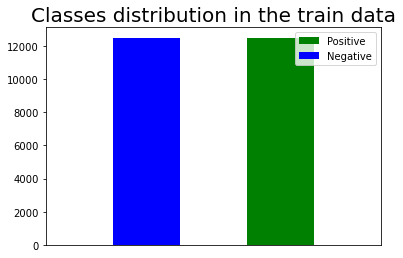

In [29]:
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data', fontsize=20)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [30]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [46]:
# nltk.download('wordnet')
# nltk.download('stopwords')

counter = 0

REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

In [47]:
X_train_data = all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values
X_submission = all_reviews[25001: 50000]

In [50]:
train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

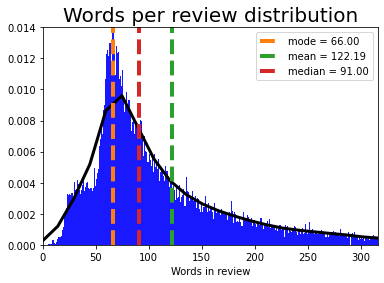

In [51]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()


In [52]:
bigrams = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [53]:
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)

In [54]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 60113


In [55]:
trigrams_model.wv.most_similar('love')

[('adore', 0.5961172580718994),
 ('cinderella', 0.5781397819519043),
 ('chatterly', 0.5445801019668579),
 ('lover', 0.5415459275245667),
 ('touch', 0.540716290473938),
 ('hate', 0.5376411080360413),
 ('heart_warm', 0.5196908712387085),
 ('heart', 0.5190286636352539),
 ('friendship', 0.5151803493499756),
 ('happy', 0.5147083401679993)]

In [56]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'gun'])

'gun'

In [57]:
trigrams_model.save("word2vec.model")